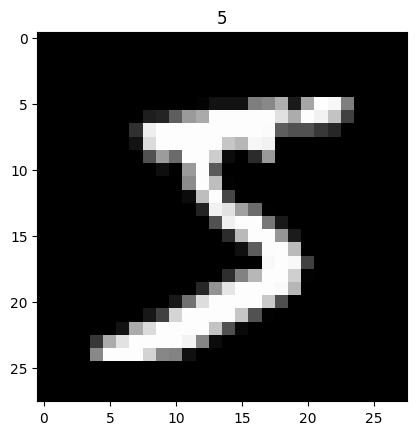

In [27]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training and test data
train_data = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
test_data  = datasets.MNIST(root='data', train=False, transform=ToTensor())
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

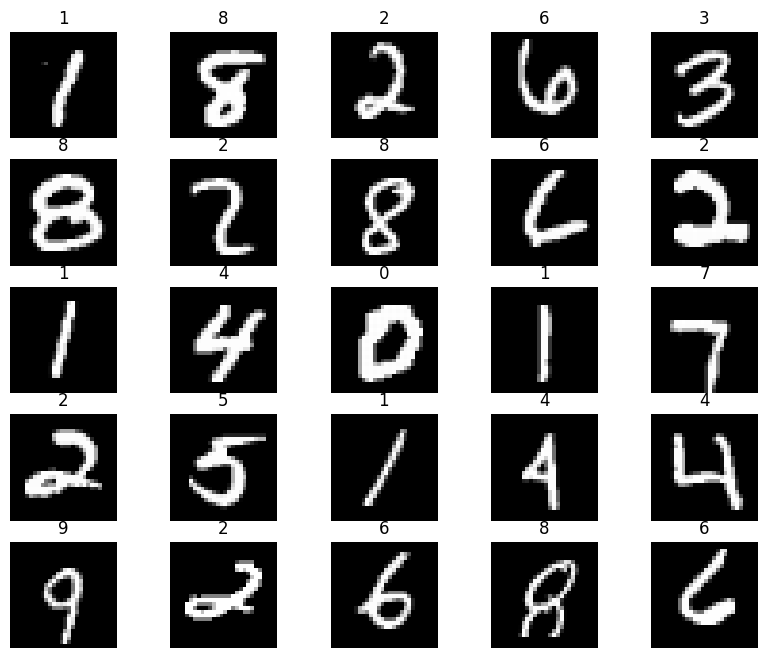

In [28]:
figure = plt.figure(figsize=(10,8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### Preparing data for training with DataLoaders

In [29]:
from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test'  : DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}

In [30]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x # return x for visualization

In [31]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [32]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [33]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    cnn.train()
# Train the model
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images) # batch x
            b_y = Variable(labels) # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch + 1, num_epochs, i + 1,
                        total_step, loss.item()))
            pass
        pass
    pass
train(num_epochs, cnn, loaders)
# clear gradients for this training step

Epoch [1/10], Step [100/600], Loss: 0.0836
Epoch [1/10], Step [200/600], Loss: 0.0724
Epoch [1/10], Step [300/600], Loss: 0.0256
Epoch [1/10], Step [400/600], Loss: 0.0224
Epoch [1/10], Step [500/600], Loss: 0.3019
Epoch [1/10], Step [600/600], Loss: 0.0258
Epoch [2/10], Step [100/600], Loss: 0.0357
Epoch [2/10], Step [200/600], Loss: 0.0159
Epoch [2/10], Step [300/600], Loss: 0.0159
Epoch [2/10], Step [400/600], Loss: 0.1121
Epoch [2/10], Step [500/600], Loss: 0.0164
Epoch [2/10], Step [600/600], Loss: 0.1047
Epoch [3/10], Step [100/600], Loss: 0.0358
Epoch [3/10], Step [200/600], Loss: 0.0774
Epoch [3/10], Step [300/600], Loss: 0.0256
Epoch [3/10], Step [400/600], Loss: 0.0119
Epoch [3/10], Step [500/600], Loss: 0.0389
Epoch [3/10], Step [600/600], Loss: 0.0622
Epoch [4/10], Step [100/600], Loss: 0.0168
Epoch [4/10], Step [200/600], Loss: 0.0013
Epoch [4/10], Step [300/600], Loss: 0.0472
Epoch [4/10], Step [400/600], Loss: 0.0907
Epoch [4/10], Step [500/600], Loss: 0.0728
Epoch [4/10

In [34]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.99


In [35]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

array([0, 7, 6, 2, 0, 7, 1, 3, 1, 1])

In [36]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [0 7 6 2 0 7 1 3 1 1]
Actual number: [0 7 6 2 0 7 1 3 1 1]
